In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `/central/groups/esm/jschmitt/experiments/feature_importance`


In [3]:
import EnsembleKalmanProcesses as EKP
import ScikitLearn
import YAML
import JLD2
import ClimaCalibrate as CAL
using Statistics
using CairoMakie
using Glob
using ClimaAnalysis
using Revise
using DataFrames
import CSV
using ColorSchemes
import CalibrateEmulateSample as CES
using FixedEffectModels

In [4]:
includet("helper_funcs.jl")
config = YAML.load_file("experiment_config.yml")

Dict{Any, Any} with 5 entries:
  "reduction_end_time"   => 108000
  "var_names_int"        => ["pr", "rlut", "rsut", "rsutcs", "rlutcs", "lwp", "…
  "reduction_start_time" => 64800
  "var_names_prof"       => ["ta", "hus", "clw", "cli", "tke", "wa", "hur", "cl…
  "z_levels"             => [100, 500, 1000, 1500, 2000, 2500, 3000, 4000]

# Single Site Experiments

In [ ]:
# Initialize a nested dictionary to store profiles
parameters = glob("perturbed/*")
param_names = basename.(parameters)


function generate_perturbation_dict(short_name, perturb_amounts; zlev = nothing)
    profiles = Dict{String, Dict{String, Any}}()

    for (i, parameter) in enumerate(parameters)
        param_name = basename(parameter)
        profiles[param_name] = Dict()
        for perturb in perturb_amounts
            try
                println("Processing parameter: $param_name, perturbation: $perturb")
                # Read the parameter file
                sim_dir = SimDir(joinpath(parameter, perturb, "output_0000"))
                data = get(sim_dir; short_name = short_name, reduction = "inst")
                if data.dims["time"][end] < config["reduction_end_time"]
                    profiles[param_name][perturb] = [NaN]
                else
                    profile = window(data, "time", left = config["reduction_start_time"], right = config["reduction_end_time"])
                    averaged_profile = average_time(slice(profile, x = 0, y = 0))

                    if !haskey(averaged_profile.dims, "z")
                        profiles[param_name][perturb] = averaged_profile.data
                    else
                        profiles[param_name][perturb] = slice(averaged_profile, z = zlev).data
                    end
                    # Store the averaged profile in the nested dictionary
                end
            catch e 
                println("Error processing parameter: $param_name, perturbation: $perturb")
                println(e)
                profiles[param_name][perturb] = [NaN]
            end
        end
    end
    return profiles
end
profiles = generate_perturbation_dict("pr", string.(collect(.5:0.05:1.5)), zlev = 100)
# slice(profiles[param_names[2]]["1.0"], z = 4000).data[1]

Dict{String, Dict{String, Any}} with 11 entries:
  "mixing_length_tke_surf_… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>fill(-…
  "mixing_length_diss_coef… => Dict("1.35"=>[NaN], "0.9"=>fill(-2.15967f-5), "0…
  "diagnostic_covariance_c… => Dict("1.35"=>fill(-2.55075f-5), "0.9"=>[NaN], "0…
  "entr_param_vec"          => Dict("1.35"=>fill(-2.5104f-5), "0.9"=>[NaN], "0.…
  "EDMF_surface_area"       => Dict("1.35"=>fill(-2.54828f-5), "0.9"=>fill(-2.1…
  "mixing_length_eddy_visc… => Dict("1.35"=>fill(-2.26922f-5), "0.9"=>fill(-2.2…
  "turb_entr_param_vec"     => Dict("1.35"=>fill(-2.58302f-5), "0.9"=>[NaN], "0…
  "pressure_normalmode_dra… => Dict("1.35"=>fill(-2.70024f-5), "0.9"=>fill(-2.3…
  "mixing_length_Prandtl_n… => Dict("1.35"=>fill(-2.32426f-5), "0.9"=>fill(-2.4…
  "mixing_length_static_st… => Dict("1.35"=>fill(-2.35571f-5), "0.9"=>[NaN], "0…
  "pressure_normalmode_buo… => Dict("1.35"=>fill(-2.95094f-5), "0.9"=>fill(-2.0…

In [ ]:
profiles["EDMF_surface_area"]["1.35"][1]

296.7694f0

In [ ]:

function statistic_parameter_plot(statistic, zlev = 0; purturbations = string.(collect(.5:0.05:1.5)))
    # access the data
    profiles = generate_perturbation_dict(statistic, purturbations, zlev = zlev);

    fig = Figure(size = (250 * min(length(param_names), 5), 250 * ceil(Int, length(param_names) / 5)))  # Adjust figure size
    for (i, param_name) in enumerate(param_names)
        row = div(i - 1, 5) + 1  # Calculate row index
        col = mod(i - 1, 5) + 1  # Calculate column index
        ax = Axis(fig[row, col], title = param_name, xlabel = "Fraction of Prior Mean Value", ylabel = statistic)
        resultant_perturbed_amounts = collect(keys(profiles[param_name]))
        obs = [profiles[param_name][perturb][1] for perturb in resultant_perturbed_amounts]
        obs = hcat(obs...)[:]
        valid_idx = .!isnan.(obs)
        xvals = parse.(Float64, resultant_perturbed_amounts)[valid_idx]
        obs = obs[valid_idx]
        scatter!(ax, xvals, obs, label = "Observations")
    end

    fig
    # save fig 
    save("figures/single_var_perturbations/$(statistic)_$(zlev).png", fig)
    return profiles
end

statistic_parameter_plot("pr", 0)

Dict{String, Dict{String, Any}} with 11 entries:
  "mixing_length_tke_surf_… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>fill(-…
  "mixing_length_diss_coef… => Dict("1.35"=>[NaN], "0.9"=>fill(-2.15967f-5), "0…
  "diagnostic_covariance_c… => Dict("1.35"=>fill(-2.55075f-5), "0.9"=>[NaN], "0…
  "entr_param_vec"          => Dict("1.35"=>fill(-2.5104f-5), "0.9"=>[NaN], "0.…
  "EDMF_surface_area"       => Dict("1.35"=>fill(-2.54828f-5), "0.9"=>fill(-2.1…
  "mixing_length_eddy_visc… => Dict("1.35"=>fill(-2.26922f-5), "0.9"=>fill(-2.2…
  "turb_entr_param_vec"     => Dict("1.35"=>fill(-2.58302f-5), "0.9"=>[NaN], "0…
  "pressure_normalmode_dra… => Dict("1.35"=>fill(-2.70024f-5), "0.9"=>fill(-2.3…
  "mixing_length_Prandtl_n… => Dict("1.35"=>fill(-2.32426f-5), "0.9"=>fill(-2.4…
  "mixing_length_static_st… => Dict("1.35"=>fill(-2.35571f-5), "0.9"=>[NaN], "0…
  "pressure_normalmode_buo… => Dict("1.35"=>fill(-2.95094f-5), "0.9"=>fill(-2.0…

In [ ]:
for statistic in config["y_var_names"]
    println(statistic)
    if statistic in ["ta", "hus", "clw", "cli"]
        for zlev in [100, 500, 1000, 1500, 2000, 2500]
            statistic_parameter_plot(statistic, zlev);
        end
    else 
        statistic_parameter_plot(statistic, 0);
    end
end

UndefVarError: UndefVarError: `experiment_config` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
t = generate_perturbation_dict("pr",  string.(collect(.5:0.05:1.5)), zlev = 0)

Dict{String, Dict{String, Any}} with 11 entries:
  "mixing_length_tke_surf_… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "mixing_length_diss_coef… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "diagnostic_covariance_c… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "entr_param_vec"          => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "EDMF_surface_area"       => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "mixing_length_eddy_visc… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "turb_entr_param_vec"     => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "pressure_normalmode_dra… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "mixing_length_Prandtl_n… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "mixing_length_static_st… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…
  "pressure_normalmode_buo… => Dict("1.35"=>[NaN], "0.9"=>[NaN], "0.95"=>[NaN],…

In [ ]:
fig = Figure(size = (250 * min(length(param_names), 5), 250 * ceil(Int, length(param_names) / 5)))  # Adjust figure size
var_name = "ta"
for (i, param_name) in enumerate(param_names)
    println(param_name)
    row = div(i - 1, 5) + 1  # Calculate row index
    col = mod(i - 1, 5) + 1  # Calculate column index
    ax = Axis(fig[row, col], title = param_name, xlabel = "Perturbation", ylabel = var_name)
    resultant_perturbed_amounts = collect(keys(profiles[param_name]))
    println(resultant_perturbed_amounts)
    obs = [profiles[param_name][perturb][1] for perturb in resultant_perturbed_amounts]
    println(obs)
    obs = hcat(obs...)[:]
    println(obs)
    @info size(resultant_perturbed_amounts)
    valid_idx = .!isnan.(obs)
    xvals = parse.(Float64, resultant_perturbed_amounts)[valid_idx]
    obs = obs[valid_idx]
    scatter!(ax, xvals, obs, label = "Observations")
end

fig
# save fig 
save("figures/single_var_perturbations/ta_100.png", fig)

In [ ]:
fig = Figure(size = (400, 1600))
for (ind, param_name) in enumerate(param_names)
    ax = Axis(fig[1, ind], title = param_name, xlabel = "Time", ylabel = "rsut")
    obs = [profiles[param_name][perturb].data for perturb in perturb_amounts]
    #obs = hcat(obs...)
    scatter!(ax, [0.8, 1.0, 1.2], obs)
end

ArgumentError: ArgumentError:     Conversion failed for Scatter (With conversion trait PointBased()) with args: Tuple{Vector{Float64}, Vector{Array{Float32, 0}}} .
    Scatter requires to convert to argument types Tuple{AbstractVector{<:Union{Point2, Point3}}}, which convert_arguments didn't succeed in.
    To fix this overload convert_arguments(P, args...) for Scatter or PointBased() and return an object of type Tuple{AbstractVector{<:Union{Point2, Point3}}}.`


In [ ]:
# read all the parameter directories
parameters = glob("perturbed/*")
# get the perturbation amounts
perturb_amounts = readdir(parameters[1])
var = "ta"

t = nothing 
for parameter in parameters
    for perturb in perturb_amounts
        # read the parameter file
        sim_dir = SimDir(joinpath(parameter, perturb, "output_active"))
        var = get(sim_dir; short_name = var, reduction = "inst")
        profile = window(t, "time", left = config["reduction_start_time"], right = config["reduction_end_time"])
        averaged_profile = average_time(slice(profile, x = 0, y = 0));
        t = var
    end
end

Attributes:
  units      => K
  short_name => ta
  long_name  => Air Temperature, Instantaneous
  start_date => 2007-07-01T00:00:00
  comments   => 
Dimension attributes:
  time:
    units         => s
    axis          => T
    long_name     => Time
    standard_name => time
  x:
    units => m
    axis  => X
  y:
    units => m
    axis  => Y
  z:
    units => m
    axis  => Z
Data defined over:
  time with 187 elements (0.0 to 111600.0)
  x    with 2 elements (0.0 to 1.0)
  y    with 2 elements (0.0 to 1.0)
  z    with 200 elements (15.0 to 44759.664)Attributes:
  units      => K
  short_name => ta
  long_name  => Air Temperature, Instantaneous
  start_date => 2007-07-01T00:00:00
  comments   => 
Dimension attributes:
  time:
    units         => s
    axis          => T
    long_name     => Time
    standard_name => time
  x:
    units => m
    axis  => X
  y:
    units => m
    axis  => Y
  z:
    units => m
    axis  => Z
Data defined over:
  time with 187 elements (0.0 to 111600

In [ ]:
profile = window(t, "time", left = config["reduction_start_time"], right = config["reduction_end_time"])
averaged_profile = average_time(slice(profile, x = 0, y = 0));



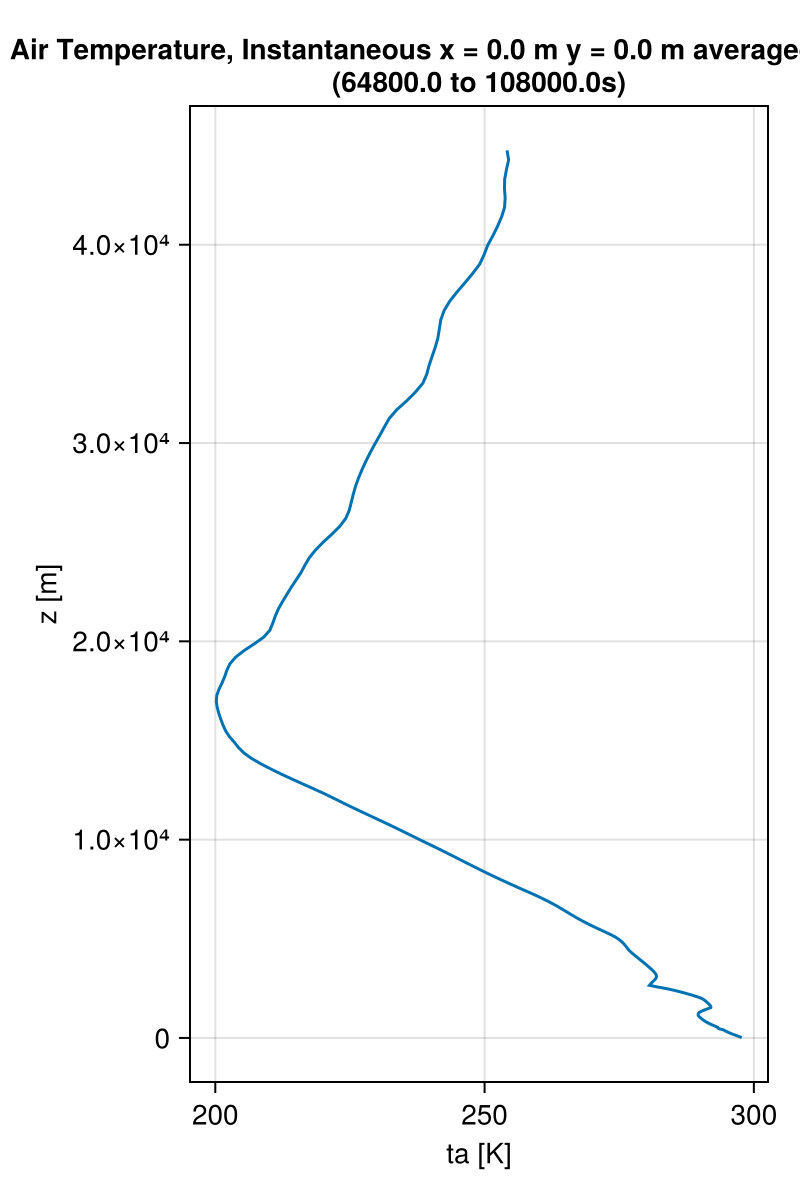

In [ ]:
fig = Figure(size = (400, 600))

Visualize.plot!(
    fig, 
    averaged_profile,
    more_kwargs = Dict(:axis => ClimaAnalysis.Utils.kwargs(dim_on_y = true)),
)
fig

# Multisite Experiments

## Dict Approach

In [5]:
# get all possible combinations
parameters = basename.(glob("multiseason_smoothed/*"))
perturbations = collect(Set(basename.(glob("multiseason_smoothed/*/*"))))
sites = collect(Set(basename.(glob("multiseason_smoothed/*/*/*01"))))

all_paths = joinpath.(vec(collect(Iterators.product([parameters, perturbations, sites]...))))

2420-element Vector{String}:
 "EDMF_surface_area/0.9/20.0_-145.0_20070101"
 "diagnostic_covariance_coeff/0.9/20.0_-145.0_20070101"
 "entr_param_vec/0.9/20.0_-145.0_20070101"
 "mixing_length_Prandtl_number_0/0.9/20.0_-145.0_20070101"
 "mixing_length_diss_coeff/0.9/20.0_-145.0_20070101"
 "mixing_length_eddy_viscosity_coefficient/0.9/20.0_-145.0_20070101"
 "mixing_length_static_stab_coeff/0.9/20.0_-145.0_20070101"
 "mixing_length_tke_surf_scale/0.9/20.0_-145.0_20070101"
 "pressure_normalmode_buoy_coeff1/0.9/20.0_-145.0_20070101"
 "pressure_normalmode_drag_coeff/0.9/20.0_-145.0_20070101"
 ⋮
 "entr_param_vec/0.6/-14.0_-105.0_20070101"
 "mixing_length_Prandtl_number_0/0.6/-14.0_-105.0_20070101"
 "mixing_length_diss_coeff/0.6/-14.0_-105.0_20070101"
 "mixing_length_eddy_viscosity_coefficient/0.6/-14.0_-105.0_20070101"
 "mixing_length_static_stab_coeff/0.6/-14.0_-105.0_20070101"
 "mixing_length_tke_surf_scale/0.6/-14.0_-105.0_20070101"
 "pressure_normalmode_buoy_coeff1/0.6/-14.0_-105.0_20070101

In [22]:
#function get_perturbation_data_dict(short_name, combo_list; zlev = nothing)
data_var = "ta"
all_paths = joinpath.(vec(collect(Iterators.product([parameters, perturbations, sites]...))))
profiles = Dict{String, Dict{String, Any}}()
for path in all_paths[100]
    dict_keys = split(path, "/")
    sim_dir = SimDir(joinpath(path, "output_active"))
    data = get(sim_dir; short_name = data_var, reduction = "inst")
    if data.dims["time"][end] < config["reduction_end_time"]
        profiles[param_name][perturb] = [NaN]
    else
        profile = window(data, "time", left = config["reduction_start_time"], right = config["reduction_end_time"])
        averaged_profile = average_time(slice(profile, x = 0, y = 0))

        if !haskey(averaged_profile.dims, "z")
            profiles[param_name][perturb] = averaged_profile.data
        else
            profiles[param_name][perturb] = slice(averaged_profile, z = zlev).data
        end
        # Store the averaged profile in the nested dictionary
    end
end

MethodError: MethodError: no method matching split(::Char, ::String)
The function `split` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  split(!Matched::T, ::Any; limit, keepempty) where T<:AbstractString
   @ Base strings/util.jl:737
  split(!Matched::AbstractString; limit, keepempty)
   @ Base strings/util.jl:744


In [ ]:
ar = []
for path in all_paths
    t = SimDir(joinpath("multiseason_smoothed", path, "output_active"))
    try
        push!(ar, get(t, "ta").dims["time"][end])
    catch 
    end
end


In [56]:
sum(ar .> config["reduction_end_time"])

1413

In [ ]:
t = SimDir(joinpath("multiseason_smoothed", all_paths[40], "output_active"))
d = get(t, "ta");
d.dims["time"][end]

36×2×2×200 Array{Float32, 4}:
[:, :, 1, 1] =
 294.42   294.42
 295.829  295.829
 295.875  295.875
 295.85   295.85
 295.825  295.825
 295.801  295.801
 295.781  295.781
 295.766  295.766
 295.754  295.754
 295.746  295.746
   ⋮      
 295.26   295.26
 295.208  295.208
 295.183  295.183
 295.173  295.173
 295.169  295.169
 295.169  295.169
 295.17   295.17
 295.177  295.177
 295.19   295.19

[:, :, 2, 1] =
 294.42   294.42
 295.829  295.829
 295.875  295.875
 295.85   295.85
 295.825  295.825
 295.801  295.801
 295.781  295.781
 295.766  295.766
 295.754  295.754
 295.746  295.746
   ⋮      
 295.26   295.26
 295.208  295.208
 295.183  295.183
 295.173  295.173
 295.169  295.169
 295.169  295.169
 295.17   295.17
 295.177  295.177
 295.19   295.19

[:, :, 1, 2] =
 294.42   294.42
 295.486  295.486
 295.525  295.525
 295.516  295.516
 295.491  295.491
 295.467  295.467
 295.448  295.448
 295.432  295.432
 295.42   295.42
 295.411  295.411
   ⋮      
 294.885  294.885
 294.839  294.839
 2

## DataFrame Approach

In [7]:
all_vars = vcat([config["var_names_int"], config["var_names_prof"]]...);

In [ ]:
# Define list to collect rows
rows = []

# get all possible combinations
parameters = basename.(glob("multiseason_smoothed/*"))
perturbations = collect(Set(basename.(glob("multiseason_smoothed/*/*"))))
sites = collect(Set(basename.(glob("multiseason_smoothed/*/*/*01"))))
all_paths = joinpath.(vec(collect(Iterators.product([parameters, perturbations, sites]...))))


zlev = 1000 # for now

for path in all_paths
    param_name, perturb, site = String.(split(path, "/"))
    perturb = parse(Float64, perturb)
    @info param_name, perturb, site

    sim_dir = SimDir(joinpath("multiseason_smoothed", path, "output_active"))
    try
        for data_var in all_vars
            data = get(sim_dir; short_name = data_var, reduction = "inst")

            if data.dims["time"][end] < config["reduction_end_time"]
                throw()
                profile = NaN  # or `missing`
            else
                profile_data = window(data, "time";
                                    left=config["reduction_start_time"],
                                    right=config["reduction_end_time"])
                averaged_profile = average_time(slice(profile_data, x=0, y=0))

                if !haskey(averaged_profile.dims, "z")
                    stat = averaged_profile.data[1]
                    push!(rows, (
                        param = param_name,
                        perturb = perturb,
                        site = site,
                        variable = data_var,
                        statistic = stat,
                    ))
                else
                    for zlev in config["z_levels"]
                        stat = slice(averaged_profile, z=zlev).data[1]
                        push!(rows, (
                            param = param_name,
                            perturb = perturb,
                            site = site,
                            variable = join([data_var, zlev], "_"),
                            statistic = stat,
                        ))
                    end
                end
            end
        end
    catch
        @info "Simulation faled for $param_name, $perturb, and $site. Appending NaNs..."
        push!(rows, (
            param = param_name,
            perturb = perturb,
            site = site, 
            variable = NaN,
            statistic = NaN,
        ))
    end
end

# Convert to DataFrame
df = DataFrame(rows)

Row,param,perturb,site,variable,statistic
,String,Float64,String,Any,Float64
1,EDMF_surface_area,0.9,20.0_-145.0_20070101,NaN,NaN
2,diagnostic_covariance_coeff,0.9,20.0_-145.0_20070101,NaN,NaN
3,entr_param_vec,0.9,20.0_-145.0_20070101,NaN,NaN
4,mixing_length_Prandtl_number_0,0.9,20.0_-145.0_20070101,NaN,NaN
5,mixing_length_diss_coeff,0.9,20.0_-145.0_20070101,NaN,NaN
6,mixing_length_eddy_viscosity_coefficient,0.9,20.0_-145.0_20070101,NaN,NaN
7,mixing_length_static_stab_coeff,0.9,20.0_-145.0_20070101,NaN,NaN
8,mixing_length_tke_surf_scale,0.9,20.0_-145.0_20070101,NaN,NaN
9,pressure_normalmode_buoy_coeff1,0.9,20.0_-145.0_20070101,NaN,NaN


In [26]:
df_cleaned = df[.!isnan.(df.statistic), :]
df_cleaned

Row,param,perturb,site,variable,statistic
,String,Float64,String,Any,Float64
1,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,pr,-1.12641e-5
2,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,rlut,290.382
3,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,rsut,125.416
4,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,rsutcs,102.639
5,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,rlutcs,296.958
6,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,lwp,0.0158875
7,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,clvi,184.28
8,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,clivi,0.0
9,mixing_length_tke_surf_scale,0.8,20.0_-145.0_20070101,ta,287.599


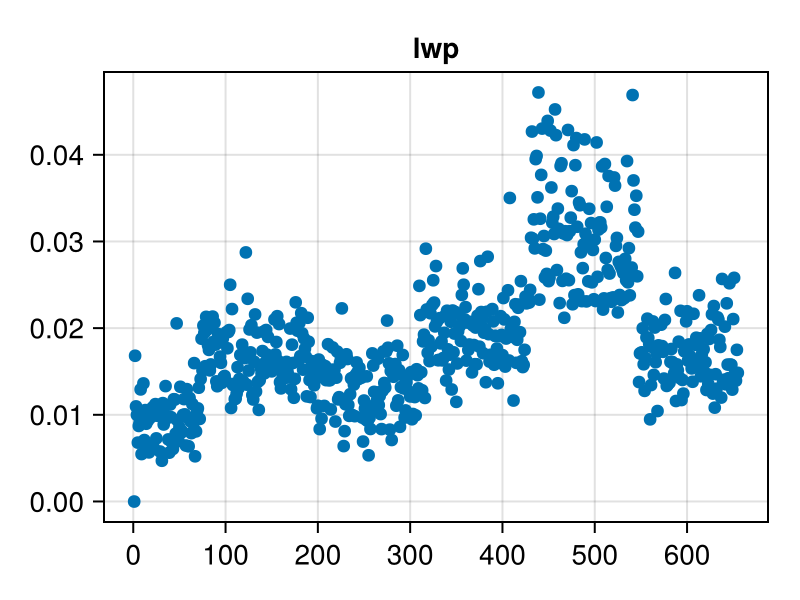

In [21]:
fig = Figure(size = (400, 300))
ax = Axis(fig[1,1], title="lwp")
scatter!(ax, filter(row -> row.variable == "lwp", df).statistic)
fig

## Read in dataframe processed from script

In [11]:
# read in csv 
df_all = CSV.read("multiseason_smoothed.csv", DataFrame)
df_all = df_all[.!isnan.(df_all.statistic), :]

# get unique entries
params = collect(Set(df_all.param))
perturbs = collect(Set(df_all.perturb))
sites = String.(collect(Set(df_all.site)))
variables = collect(Set(df_all.variable));

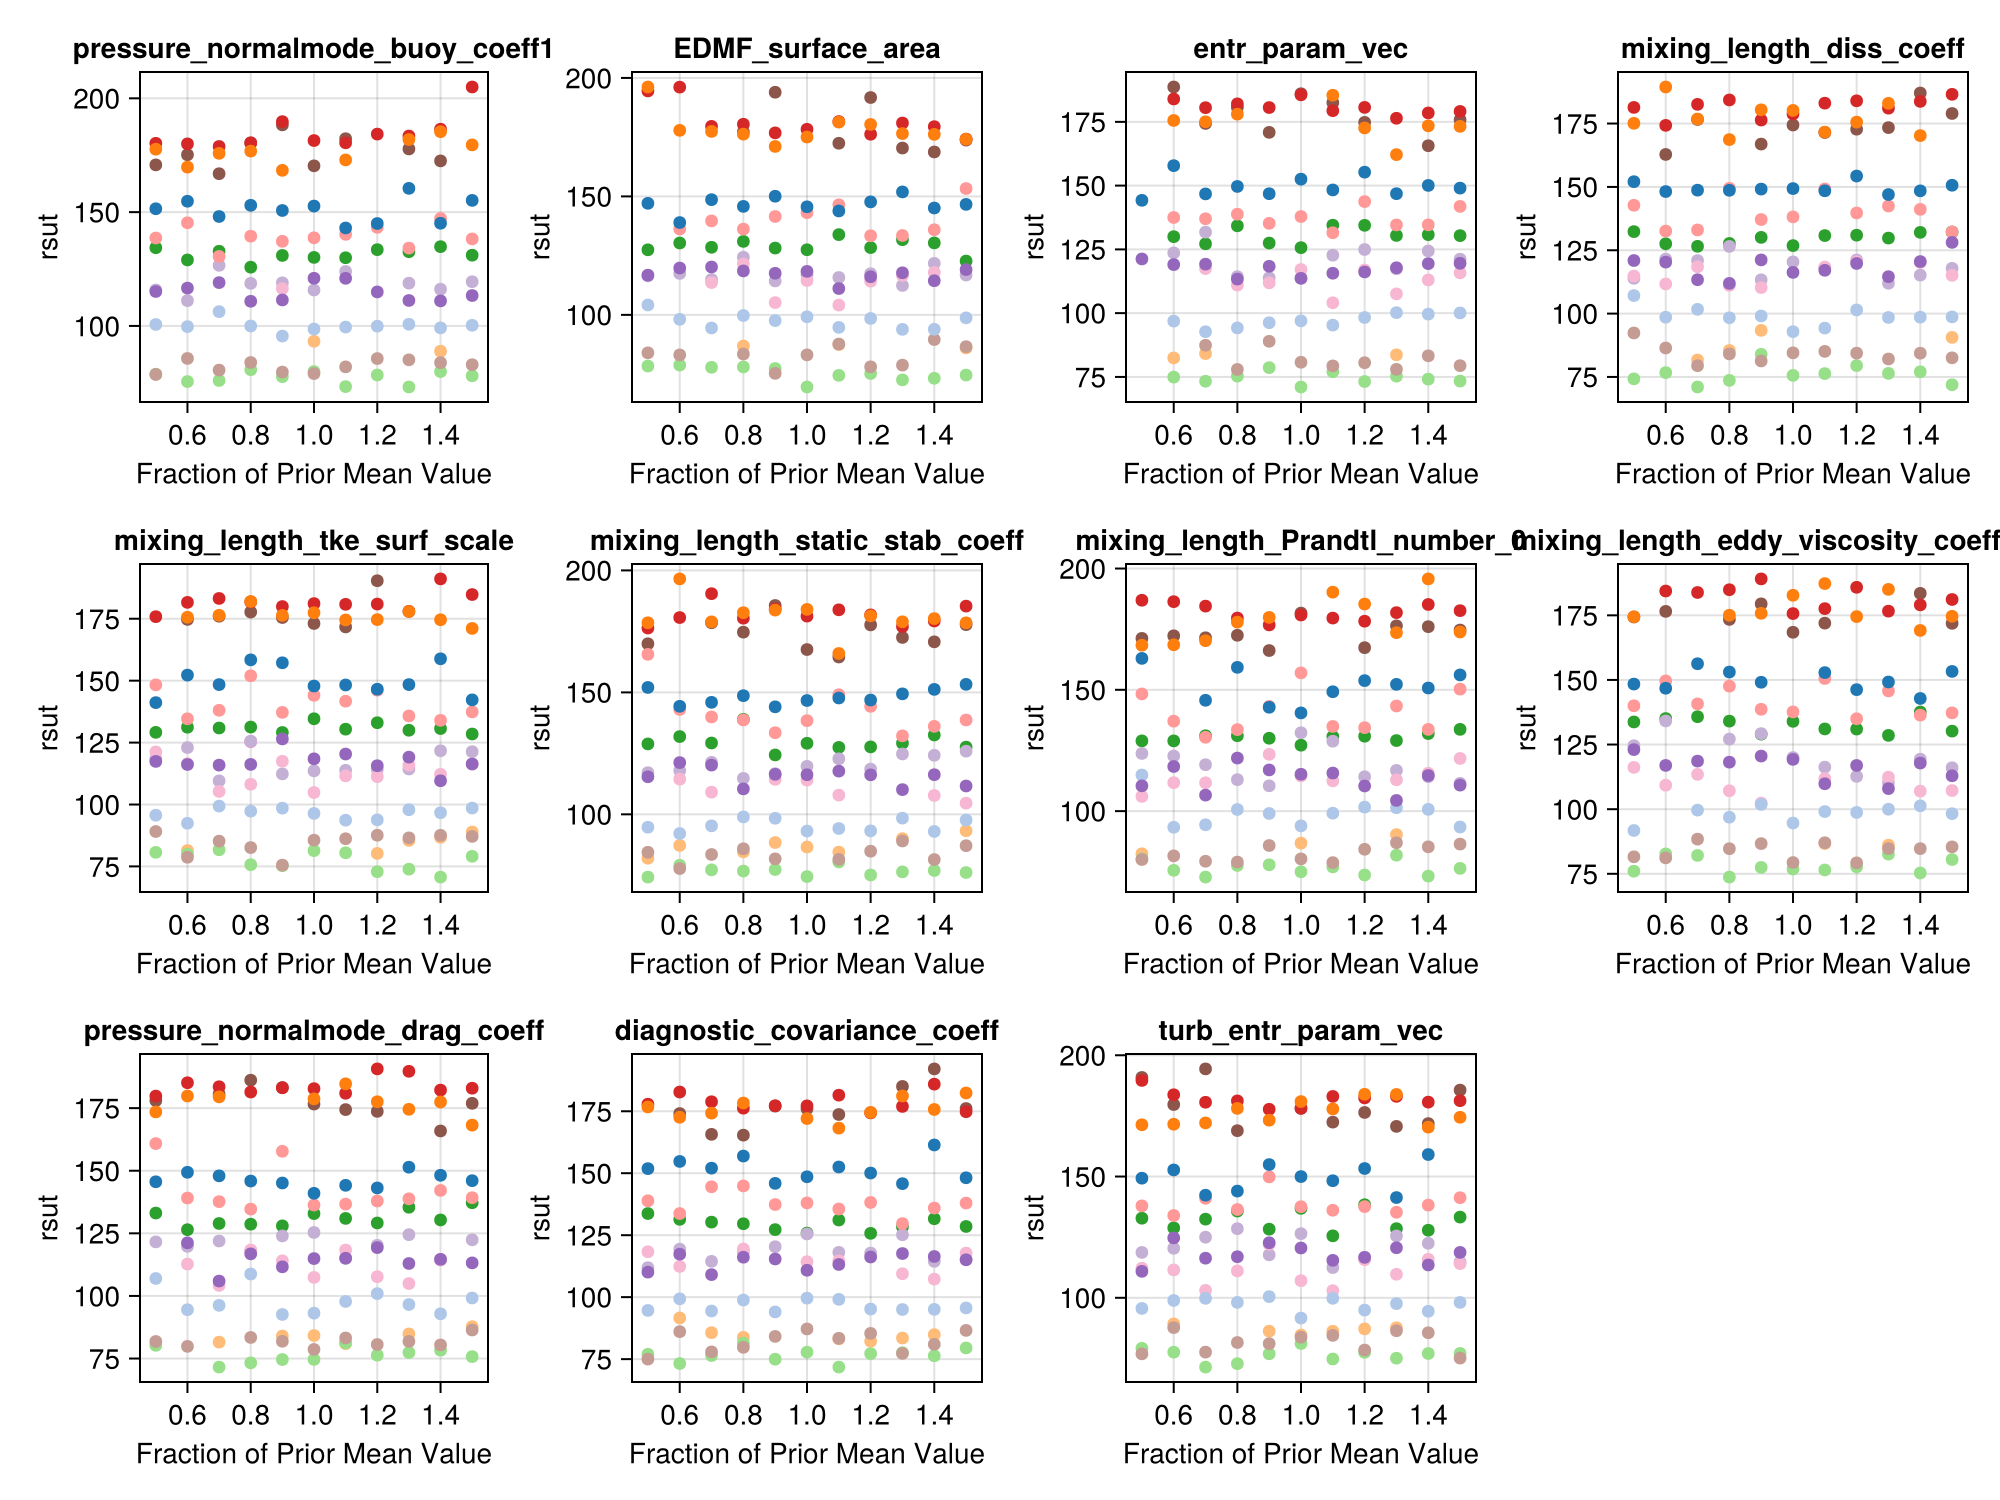

In [ ]:
# unique color scheme for each site 
palette = ColorSchemes.tab20
site2color = Dict(site => palette[i] for (i, site) in enumerate(sites))

fig = Figure(size = (250 * min(length(params), 4), 250 * ceil(Int, length(params) / 4)))  # Adjust figure size
var_ = "rsutcs "
for (i, param) in enumerate(params)
    row = div(i - 1, 4) + 1  # Calculate row index
    col = mod(i - 1, 4) + 1  # Calculate column index
    ax = Axis(fig[row, col], title = param, xlabel = "Fraction of Prior Mean Value", ylabel = "$var_")

    df_slice = filter(row -> (row.param == param) & (row.variable == var_), df_all)
    scatter!(ax, df_slice.perturb, df_slice.statistic, color=getindex.(Ref(site2color), df_slice.site))
    #ylims!(ax, 0, 1e-5)
end
fig

In [17]:
function get_regression_stats(df, param, var_)

    df_slice = filter(row -> (row.param == param) & (row.variable == var_), df)

    regression = reg(df_slice, @formula(statistic ~ perturb + fe(site)))

    d = (param = param,
        variable = var_,
        r2_within = regression.r2_within,
        coef = regression.coef,
        p = regression.p,
    )

    return regression, d
end

df_rows = []
for param in params
    for var_ in variables
        _, d = get_regression_stats(df_all, param, var_)
        push!(df_rows, d)
    end
end

coef_df = DataFrame(df_rows)

┌ Info: The variance-covariance matrix is not invertible. F-statistic not computed 
└ @ FixedEffectModels /home/jschmitt/.julia/packages/FixedEffectModels/hIepp/src/utils/tss.jl:21
┌ Info: The variance-covariance matrix is not invertible. F-statistic not computed 
└ @ FixedEffectModels /home/jschmitt/.julia/packages/FixedEffectModels/hIepp/src/utils/tss.jl:21
┌ Info: Dependent variable statistic is probably perfectly explained by fixed effects.
└ @ FixedEffectModels /home/jschmitt/.julia/packages/FixedEffectModels/hIepp/src/fit.jl:251
┌ Info: Dependent variable statistic is probably perfectly explained by fixed effects.
└ @ FixedEffectModels /home/jschmitt/.julia/packages/FixedEffectModels/hIepp/src/fit.jl:251
┌ Info: Dependent variable statistic is probably perfectly explained by fixed effects.
└ @ FixedEffectModels /home/jschmitt/.julia/packages/FixedEffectModels/hIepp/src/fit.jl:251
┌ Info: The variance-covariance matrix is not invertible. F-statistic not computed 
└ @ FixedEffectMo

Row,param,variable,r2_within,coef,p
,String,String15,Float64,Array…,Float64
1,pressure_normalmode_buoy_coeff1,cl_1500,0.0157553,[1.96105],0.197661
2,pressure_normalmode_buoy_coeff1,wa_1500,0.00168071,[-4.88987e-6],0.675021
3,pressure_normalmode_buoy_coeff1,cli_2000,NaN,[0.0],NaN
4,pressure_normalmode_buoy_coeff1,wa_4000,0.00150691,[-5.02197e-6],0.691382
5,pressure_normalmode_buoy_coeff1,cl_4000,NaN,[0.0],NaN
6,pressure_normalmode_buoy_coeff1,hus_2000,0.00602298,[-8.33764e-6],0.426874
7,pressure_normalmode_buoy_coeff1,ta_500,0.00998628,[-0.186384],0.305777
8,pressure_normalmode_buoy_coeff1,hus_2500,0.000814449,[1.00492e-7],0.770442
9,pressure_normalmode_buoy_coeff1,tke_2000,0.00374883,[-7.9614e-5],0.530991


In [32]:
df_sub = coef_df[:, [:param, :variable, :r2_within]]

df_square_r2 = unstack(df_sub, :param, :r2_within)
df_square_p = unstack(coef_df[:, [:param, :variable, :p]], :param, :p)

Row,variable,pressure_normalmode_buoy_coeff1,EDMF_surface_area,entr_param_vec,mixing_length_diss_coeff,mixing_length_tke_surf_scale,mixing_length_static_stab_coeff,mixing_length_Prandtl_number_0,mixing_length_eddy_viscosity_coefficient,pressure_normalmode_drag_coeff,diagnostic_covariance_coeff,turb_entr_param_vec
,String15,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,cl_1500,0.197661,0.390766,0.243149,0.0762454,0.477237,0.0812812,0.191693,0.0783895,0.246827,0.926206,0.109089
2,wa_1500,0.675021,0.975379,0.202543,0.0596956,0.194779,0.0653854,0.257464,0.0395019,0.437347,0.487248,0.233932
3,cli_2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.161032,NaN,NaN
4,wa_4000,0.691382,0.737159,0.139968,0.0648239,0.184116,0.0520167,0.246127,0.130284,0.219586,0.221659,0.309604
5,cl_4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,hus_2000,0.426874,0.209371,0.161924,0.265474,0.25625,0.17872,0.0403472,0.860537,0.578714,0.963648,0.383699
7,ta_500,0.305777,0.0614671,0.126718,0.278389,0.4828,0.818486,0.575995,0.0795043,0.365322,0.795148,0.0988065
8,hus_2500,0.770442,0.00937865,0.163715,0.000641493,0.431782,0.199815,0.251495,0.00558714,0.231126,0.490926,0.354344
9,tke_2000,0.530991,0.162297,0.180208,0.00479484,0.134021,0.0828516,0.112331,0.19359,0.149797,0.278577,0.570294


In [80]:
df_square_r2_sorted = df_square_r2[sortperm(df_square_r2.variable), :]
df_square_r2_sorted


Row,variable,pressure_normalmode_buoy_coeff1,EDMF_surface_area,entr_param_vec,mixing_length_diss_coeff,mixing_length_tke_surf_scale,mixing_length_static_stab_coeff,mixing_length_Prandtl_number_0,mixing_length_eddy_viscosity_coefficient,pressure_normalmode_drag_coeff,diagnostic_covariance_coeff,turb_entr_param_vec
,String15,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,cl_100,0.00088818,0.0133255,0.000729344,0.00244188,0.000186371,0.00133375,0.000783901,0.154598,0.00334542,0.00159335,0.00667123
2,cl_1000,5.76484e-5,5.40011e-5,1.86715e-5,0.00029001,0.00218891,0.00819027,0.0591793,0.0129165,0.0052419,0.00859153,0.00244208
3,cl_1500,0.0157553,0.00658359,0.0128277,0.0266188,0.00428981,0.0251072,0.0146481,0.0281484,0.0116448,7.23886e-5,0.0209062
4,cl_2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0170107,NaN,NaN
5,cl_2500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,cl_3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,cl_4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,cl_500,0.017789,0.0189792,0.00420177,0.0150231,0.0120926,0.000960408,0.0119712,0.0146705,0.00212955,9.07486e-5,0.00735341
9,cli_100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


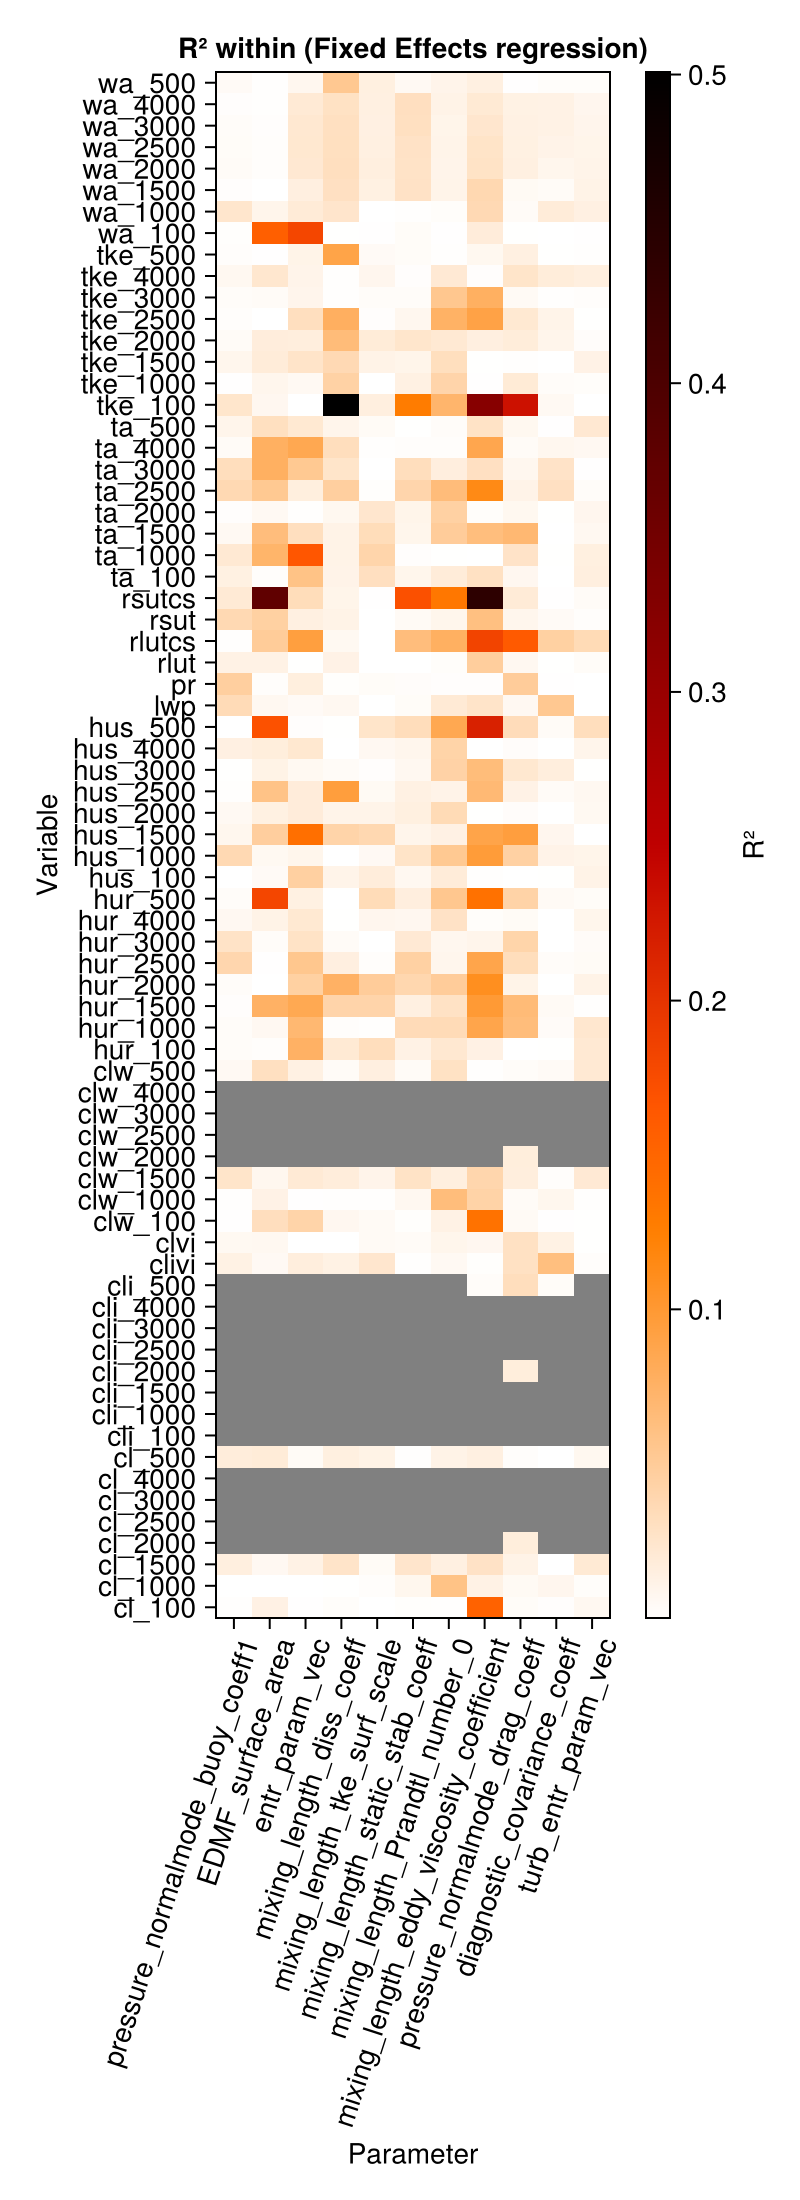

In [81]:
# visualize 
y_labels = df_square_r2_sorted.variable
x_labels = String.(names(df_square_r2_sorted))
filter!(e -> e ∉ ["variable"], x_labels) # remove the variable column


# z = Matrix(df_square_r2[filter(x -> x != "variable", names(df_square_r2))])
z = Matrix(df_square_r2_sorted[:, x_labels])

fig = Figure(size = (400, 1100))

ax = Axis(fig[1, 1],
    xticks = (1:length(x_labels), x_labels),
    yticks = (1:length(y_labels), y_labels),
    xlabel = "Parameter",
    ylabel = "Variable",
    title = "R² within (Fixed Effects regression)",
    #yreversed = true,  # top-to-bottom variable order
)
ax.xticklabelrotation = π/2.5

hm = heatmap!(ax, transpose(z); colormap = Reverse(:gist_heat), nan_color = :grey)

Colorbar(fig[1, 2], hm, label = "R²")

fig

Gradient Symbol/Strings:
    Accent
    Accent_3
    Accent_4
    Accent_5
    Accent_6
    Accent_7
    Accent_8
    Anemone
    Archambault
    AsteroidCity1
    AsteroidCity2
    AsteroidCity3
    Austria
    Bay
    Benedictus
    Blues
    Blues_3
    Blues_4
    Blues_5
    Blues_6
    Blues_7
    Blues_8
    Blues_9
    BottleRocket1
    BottleRocket2
    BrBG
    BrBG_10
    BrBG_11
    BrBG_3
    BrBG_4
    BrBG_5
    BrBG_6
    BrBG_7
    BrBG_8
    BrBG_9
    BrBg
    BuGn
    BuGn_3
    BuGn_4
    BuGn_5
    BuGn_6
    BuGn_7
    BuGn_8
    BuGn_9
    BuPu
    BuPu_3
    BuPu_4
    BuPu_5
    BuPu_6
    BuPu_7
    BuPu_8
    BuPu_9
    CMRmap
    Cascades
    Cassatt1
    Cassatt2
    Catppuccin_frappe
    Catppuccin_latte
    Catppuccin_macchiato
    Catppuccin_mocha
    Cavalcanti1
    Chevalier1
    Cross
    Darjeeling1
    Darjeeling2
    Dark2
    Dark2_3
    Dark2_4
    Dark2_5
    Dark2_6
    Dark2_7
    Dark2_8
    Degas
    Demuth
    Derain
    Egypt
    Fantasti

In [40]:
pop!(x_labels, "variable")

MethodError: MethodError: no method matching pop!(::Vector{String}, ::String)
The function `pop!` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  pop!(!Matched::Base.EnvDict, ::AbstractString, !Matched::Any)
   @ Base env.jl:173
  pop!(!Matched::Base.EnvDict, ::AbstractString)
   @ Base env.jl:172
  pop!(!Matched::TerminalLoggers.StickyMessages, ::Any)
   @ TerminalLoggers ~/.julia/packages/TerminalLoggers/FYGc9/src/StickyMessages.jl:111
  ...


In [ ]:
# lets rip some fe regression models
using FixedEffectModels

param = params[2]
var_ = "rsut"

# subset df based on param and variable combination
df_slice = filter(row -> (row.param == param) & (row.variable == var_), df_all)

regression = reg(df_slice, @formula(statistic ~ perturb + fe(site)))

                           FixedEffectModel                           
Number of obs:                 126   Converged:                    true
dof (model):                     1   dof (residuals):               113
R²:                          0.982   R² adjusted:                 0.980
F-statistic:               5.34242   P-value:                     0.023
R² within:                   0.046   Iterations:                      1
         Estimate  Std. Error    t-stat  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
perturb  -3.37621      1.4607  -2.31137    0.0226   -6.27011  -0.482303
